# Result Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


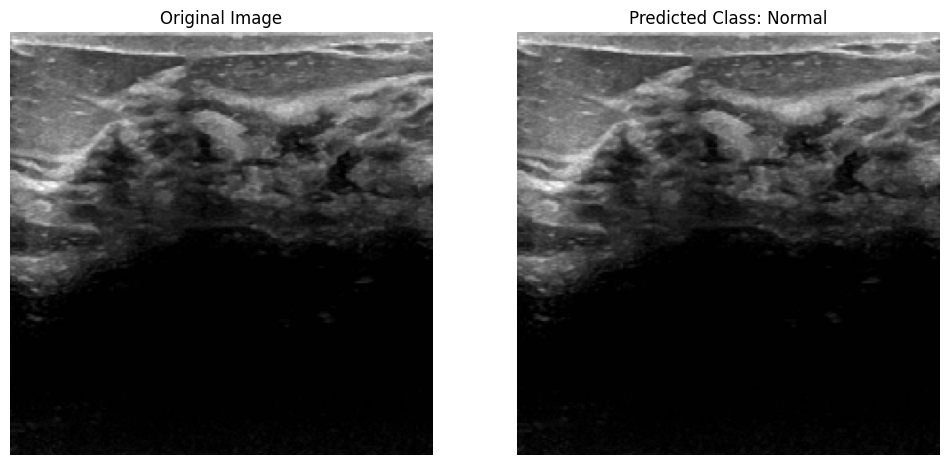

In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from skimage.transform import resize  # For resizing the heatmap
from scipy.ndimage import gaussian_filter  # For heatmap smoothing

# Load the saved model
model_path = '/kaggle/working/DNBCD_Model.h5'  # Path to your saved model
model = load_model(model_path)

# Function to generate Grad-CAM heatmap with subplots
def plot_heatmap_with_subplots(model, image_path, last_conv_layer_name='last_conv_layer'):
    # Load and preprocess the image
    img = load_img(image_path, target_size=(224, 224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0) / 255.0  # Scale image between 0 and 1

    # Get the model's prediction and determine the predicted class
    preds = model.predict(x)
    predicted_class = np.argmax(preds[0])

    # Map predicted class to label
    if predicted_class == 0:
        label = "Benign"
    elif predicted_class == 1:
        label = "Malignant"
    else:
        label = "Normal"

    # Create subplots based on the predicted class
    fig = plt.figure(figsize=(18, 6)) if label != "Normal" else plt.figure(figsize=(12, 6))

    # Subplot 1: Original image
    ax1 = fig.add_subplot(1, 3 if label != "Normal" else 2, 1)
    ax1.imshow(img)
    ax1.set_title('Original Image')
    ax1.axis('off')

    # Subplot 2: Original image with predicted class label
    ax2 = fig.add_subplot(1, 3 if label != "Normal" else 2, 2)
    ax2.imshow(img)
    ax2.set_title(f'Predicted Class: {label}')
    ax2.axis('off')

    # Only generate Grad-CAM if the predicted class is not "Normal"
    if label != "Normal":
        # Create the Grad-CAM model
        grad_model = Model(inputs=model.input, outputs=[model.get_layer(last_conv_layer_name).output, model.output])

        # Compute gradients of the predicted class with respect to the output feature map of the last conv layer
        with tf.GradientTape() as tape:
            conv_outputs, predictions = grad_model(x)
            loss = predictions[:, predicted_class]

        # Compute the gradients
        grads = tape.gradient(loss, conv_outputs)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

        # Multiply each channel by the pooled gradient values to generate the heatmap
        conv_outputs = conv_outputs[0]
        heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
        heatmap = np.maximum(heatmap, 0) / np.max(heatmap)  # Normalize the heatmap

        # Resize the heatmap to match the original image size
        heatmap_resized = resize(heatmap, (img.size[1], img.size[0]))

        # Apply Gaussian smoothing to the heatmap
        heatmap_smoothed = gaussian_filter(heatmap_resized, sigma=2)

        # Find the maximum activation point in the heatmap
        max_index = np.unravel_index(np.argmax(heatmap_resized), heatmap_resized.shape)
        max_y, max_x = max_index

        # Subplot 3: Smoothed Grad-CAM heatmap with circle marking
        ax3 = fig.add_subplot(1, 3, 3)
        ax3.imshow(img)
        ax3.imshow(heatmap_smoothed, cmap='jet', alpha=0.5)
        ax3.set_title('Grad-CAM Heatmap with Circle Marking')
        ax3.axis('off')

        # Draw a circle around the maximum activation point on the Grad-CAM heatmap
        circle_radius = 20  # Adjust the radius as needed
        circle = plt.Circle((max_x, max_y), circle_radius, color='black', fill=False, linewidth=2)
        ax3.add_patch(circle)

    # Save the figure and show it
    plt.savefig("Result_Prediction.png", dpi=600, bbox_inches='tight')
    plt.show()

# Example usage of Grad-CAM with subplots
image_path = '/kaggle/input/d/sabahesaraki/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/normal/normal (10).png'
plot_heatmap_with_subplots(model, image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


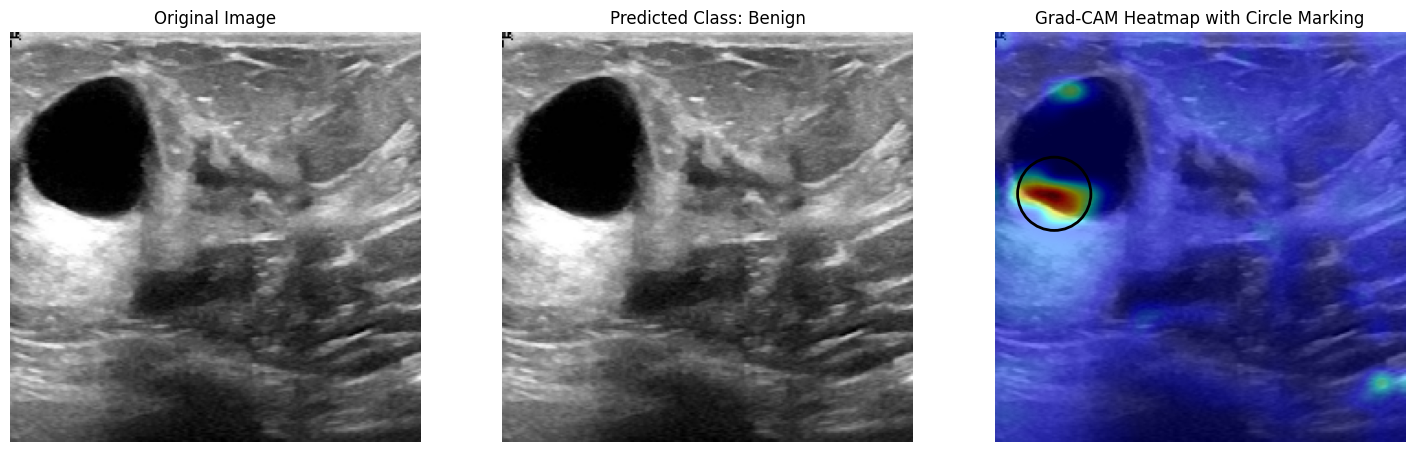

In [21]:
image_path = '/kaggle/input/d/sabahesaraki/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (10).png'
plot_heatmap_with_subplots(model, image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


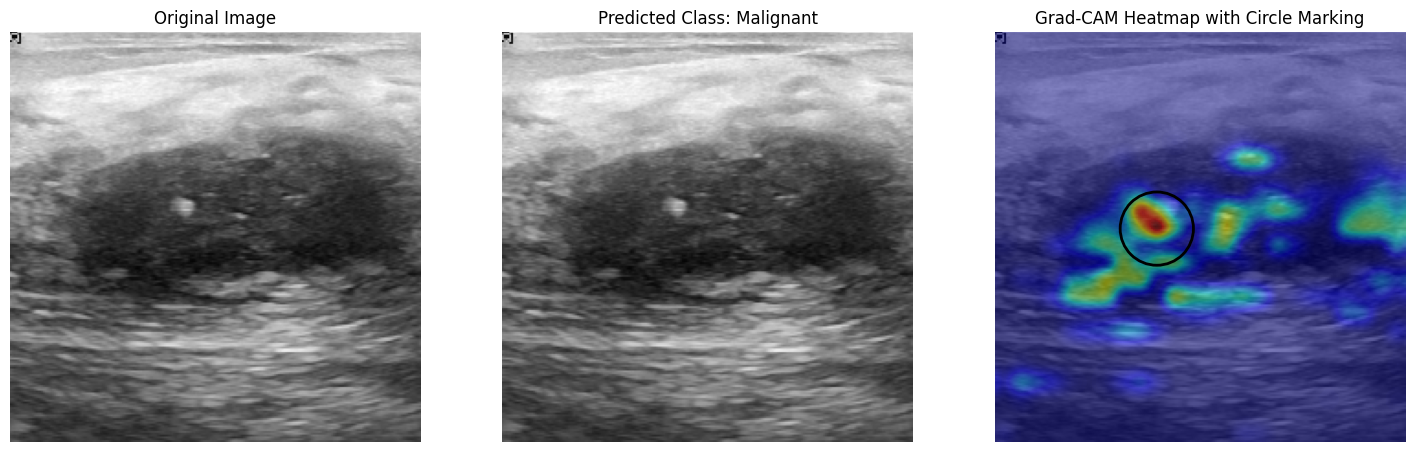

In [19]:
image_path = '/kaggle/input/d/sabahesaraki/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant/malignant (1).png'
plot_heatmap_with_subplots(model, image_path)

# Incorrect Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


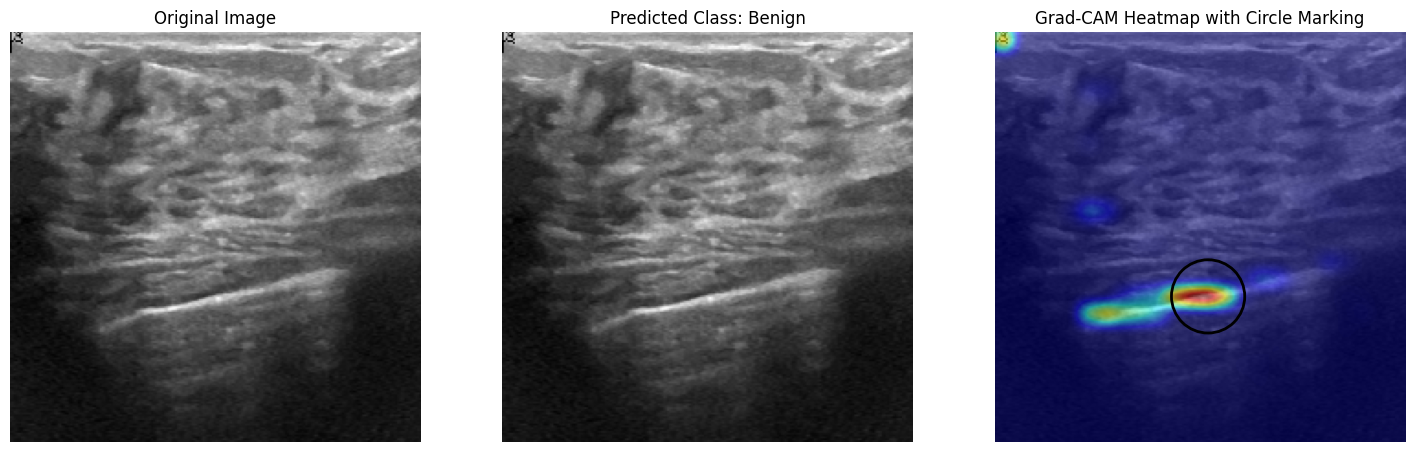

In [20]:
image_path = '/kaggle/input/d/sabahesaraki/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/normal/normal (1).png'
plot_heatmap_with_subplots(model, image_path)